# This notebook take the input from omega_analysis.ipynb output omega*.npy, and using {} to cluster them.

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from collections import Counter
from tqdm.notebook import tqdm
from deeptime.clustering import KMeans
from deeptime.clustering import RegularSpace
from deeptime.clustering import BoxDiscretization

import mdtraj as md
import re, math, os, shutil

import warnings; warnings.simplefilter('ignore')

### Import the data 

In [3]:
# import omega data
omegas = np.load('omega_data/omegas_state0.npy')
print(omegas)
print(f"omegas.shape: {omegas.shape}")
print(f"omegas.dtype: {omegas.dtype}")

[[-147.41861     160.16226    -176.02151   ]
 [-158.49817     147.35365    -159.85147   ]
 [-173.71101    -162.60245    -163.55423   ]
 ...
 [-164.01282      -3.5838215   169.54277   ]
 [ 152.39189      -0.50788236  175.81409   ]
 [-166.39548      26.654472    177.28368   ]]
omegas.shape: (2501, 3)
omegas.dtype: float32


Saved at: omega_data/Omega_angles_vs_Time_state_0_in_19AE1-4-A.png


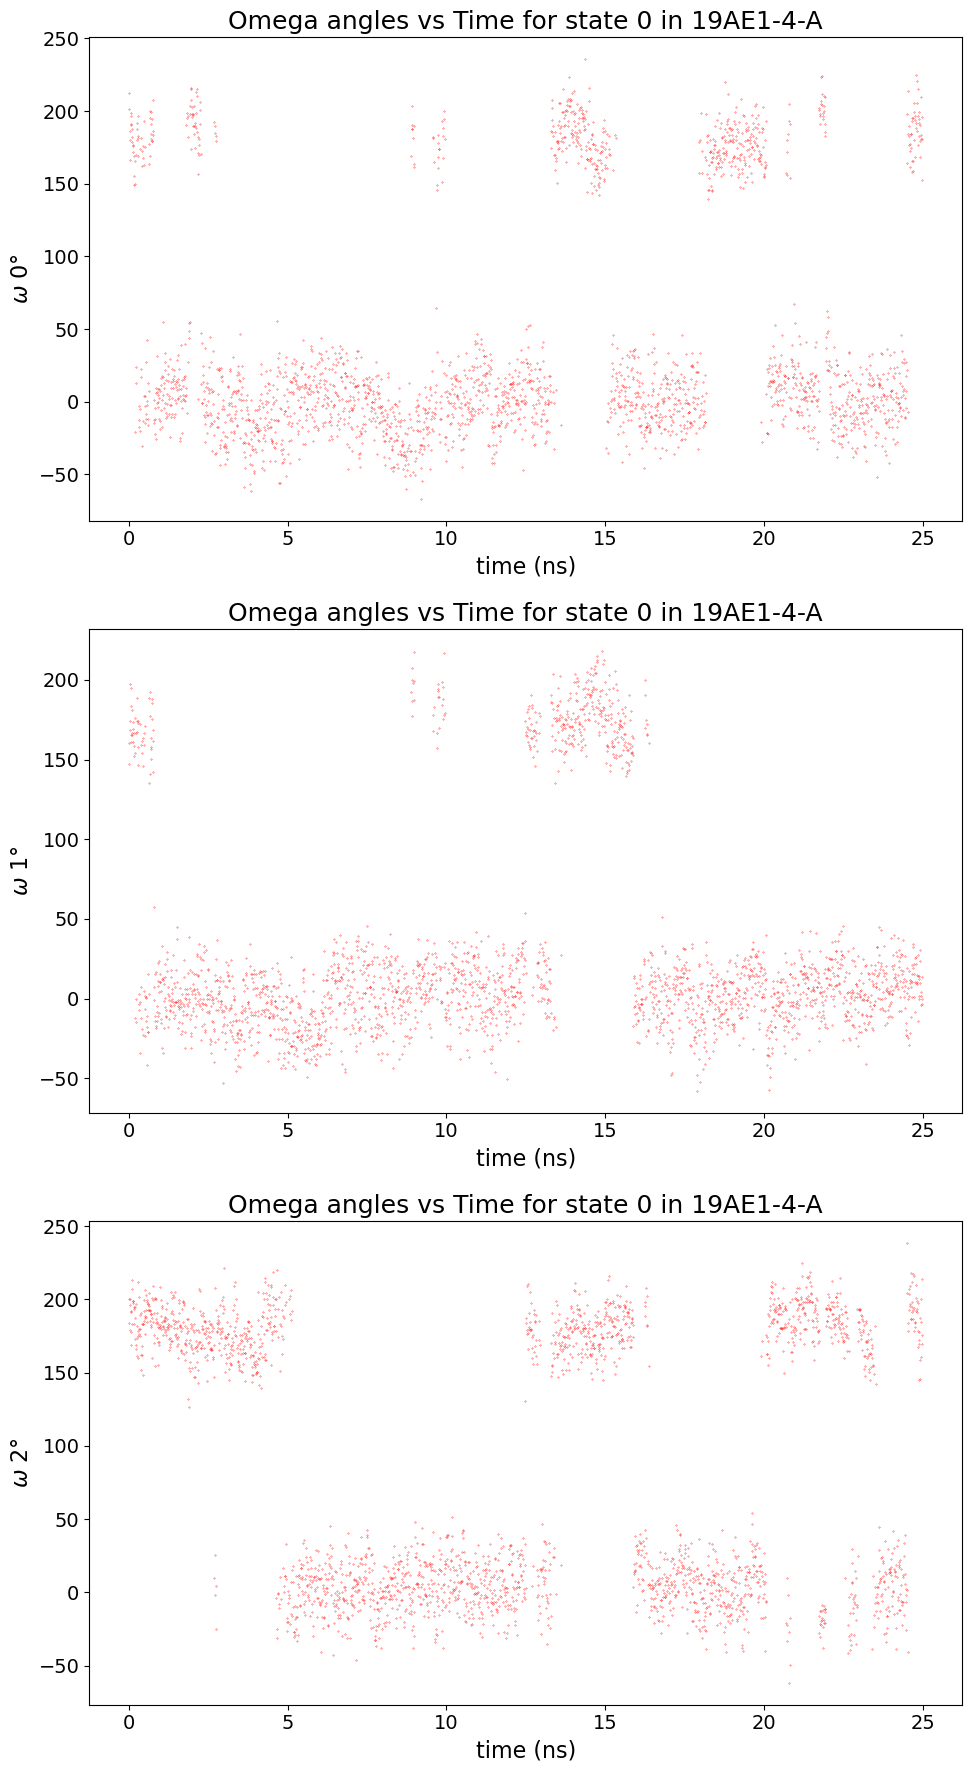

In [4]:
# Plotting the omegas 
omegas = (omegas + 90.0) % 360.0 - 90.0 # Adjust omega values into the range (-90, 270)

start = 0
nsnaps = 2500
t = np.arange(start, nsnaps) * 0.01 # Time axis in ns
residues_to_plot = [0, 1, 2,]
num_residues = len(residues_to_plot)

# Set default font sizes globally
plt.rc('font', size=16)         # controls default text sizes
plt.rc('axes', titlesize=18)    # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)   # fontsize of the tick labels
plt.rc('ytick', labelsize=14)   # fontsize of the tick labels
plt.rc('legend', fontsize=18)   # legend fontsize

plt.figure(figsize=(10, 18))
for panel, residue in enumerate(residues_to_plot, 1):
    plt.subplot(num_residues, 1, panel)
    plt.plot(t, omegas[start:nsnaps, residue], '.', ms=0.5, color='red')
    plt.xlabel('time (ns)')
    plt.ylabel(f'$\\omega$ {residue}°')
    plt.title(f'Omega angles vs Time for state 0 in 19AE1-4-A')

plt.tight_layout()

# Ensure the directory exists
outfilename = f'omega_data/Omega_angles_vs_Time_state_0_in_19AE1-4-A.png'
plt.savefig(outfilename, transparent=True, dpi=600)
print(f"Saved at: {outfilename}")
plt.show()

### Clustering Method

In [5]:
regularspace_estimator = RegularSpace(
    dmin=170,        # minimum distance between cluster centers, 180 degree
    max_centers=8,   # maximum number of cluster centers
    n_jobs=8
)

kmean_estimator = KMeans(
    n_clusters=8,              # place 100 cluster centers
    init_strategy='kmeans++',  # kmeans++ initialization strategy
    max_iter=100000000,        # don't actually perform the optimization, just place centers
    fixed_seed=42,             # Treat this as hyperparameter 
    n_jobs=8,
    progress=tqdm
)

In [6]:
# Fit the omegas data into model 
clustering = regularspace_estimator.fit(omegas).fetch_model()
assignments = clustering.transform(omegas)

print(clustering.cluster_centers)
print(f"Number of cluster centers: {len(clustering.cluster_centers)}")

[[212.58139   160.16226   183.97849  ]
 [-21.000229  -11.809013  173.21884  ]
 [195.41138    -9.766785  186.39142  ]
 [192.5105    -39.770412    9.925827 ]
 [  0.8514557  -5.2298203  -4.096367 ]
 [169.1333    192.25104   -12.671356 ]
 [  3.5965118 173.91296   130.75069  ]]
Number of cluster centers: 7


### The population of each cluster:

In [7]:
# count the number of each cluter 
counts = Counter(assignments)
#print(counts)

# Sort the counts 
sorted_counts = dict(sorted(counts.items()))
total_counts = sum(counts.values())
cluster = []

for label, frequency in sorted_counts.items():    
    precentage = (frequency / total_counts) * 100 
    cluster.append(precentage)
    print(f"Assignment {label}: {frequency}, {precentage:.4g}%")

outfile = 'clusters_probability.dat'
np.savetxt(outfile, cluster)

Assignment 0: 231, 9.236%
Assignment 1: 672, 26.87%
Assignment 2: 88, 3.519%
Assignment 3: 230, 9.196%
Assignment 4: 1132, 45.26%
Assignment 5: 28, 1.12%
Assignment 6: 120, 4.798%


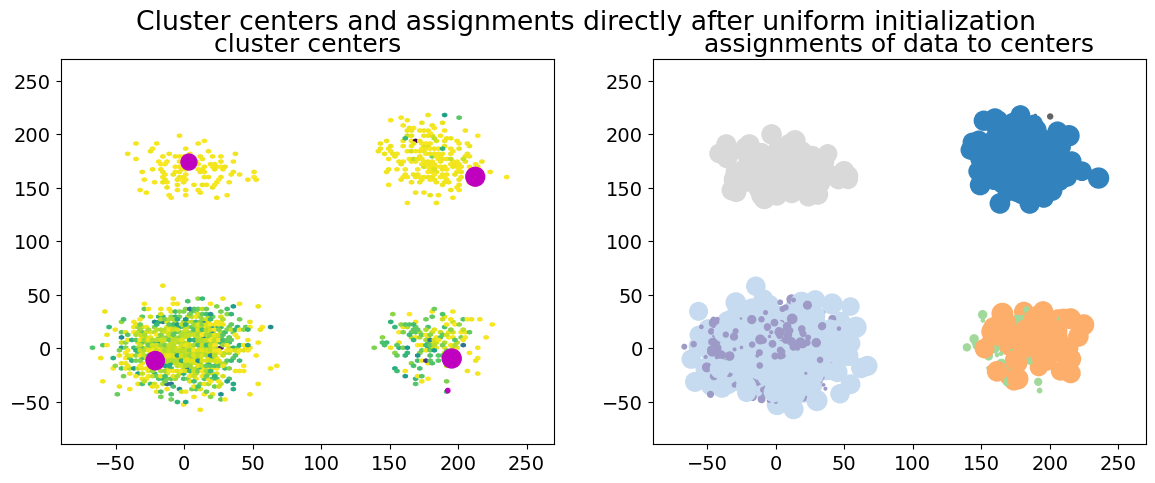

In [8]:
# Plotting the results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
f.suptitle('Cluster centers and assignments directly after uniform initialization')

# Adjust display range
x_min, x_max = -90, 270
y_min, y_max = -90, 270

# First plot: hexbin and cluster centers
ax1.hexbin(*(omegas.T), bins='log')
ax1.scatter(*(clustering.cluster_centers.T), marker='o', c='m')
ax1.axis('on')
ax1.set_xlim(x_min, x_max)  # Set x-axis range
ax1.set_ylim(y_min, y_max)  # Set y-axis range
ax1.set_title('cluster centers')

# Second plot: scatter plot of assignments
ax2.scatter(*(omegas.T), c=assignments, cmap='tab20c')
ax2.axis('on')
ax2.set_xlim(x_min, x_max)  # Set x-axis range
ax2.set_ylim(y_min, y_max)  # Set y-axis range
ax2.set_title('assignments of data to centers')

# Show the plots
plt.show()

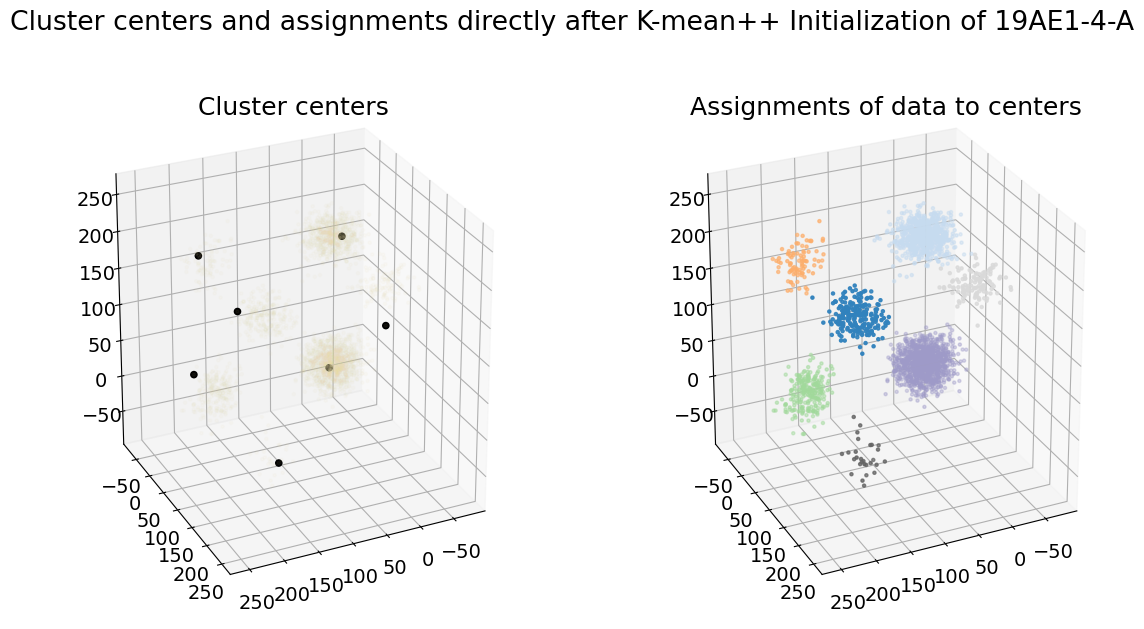

In [9]:
fig = plt.figure(figsize=(14, 7))

# Set the display range
x_min, x_max = -90, 270
y_min, y_max = -90, 270
z_min, z_max = -90, 270

# Viewing angles
elevation = 25  # Example elevation angle
azimuth = 65    # Example azimuthal angle

# Create a 3D subplot for cluster centers
ax1 = fig.add_subplot(121, projection='3d')
ax1.set_title('Cluster centers')
ax1.scatter(omegas[:, 0], omegas[:, 1], omegas[:, 2], c='#E6DAA6', marker='.', alpha=0.05)
ax1.scatter(clustering.cluster_centers[:, 0], clustering.cluster_centers[:, 1], clustering.cluster_centers[:, 2], c='k', marker='o', alpha=1)
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min, y_max)
ax1.set_zlim(z_min, z_max)
ax1.view_init(elev=elevation, azim=azimuth)  # Set the viewing angle

# Create a 3D subplot for assignments
ax2 = fig.add_subplot(122, projection='3d')
ax2.set_title('Assignments of data to centers')
ax2.scatter(omegas[:, 0], omegas[:, 1], omegas[:, 2], c=assignments[:], marker='.', cmap='tab20c')
ax2.set_xlim(x_min, x_max)
ax2.set_ylim(y_min, y_max)
ax2.set_zlim(z_min, z_max)
ax2.view_init(elev=elevation, azim=azimuth)  # Set the viewing angle

fig.suptitle('Cluster centers and assignments directly after K-mean++ Initialization of 19AE1-4-A')
fig.savefig('omega_data/cluster_centers_and_assignments.png', transparent=True, dpi=600, bbox_inches='tight')
plt.show()

### Plot the Solution NMR Crystal Structure 

In [10]:
gmx_dihedral_indices =[
    [2, 3, 18, 19],
    [19, 20, 41, 42],
    [42, 43, 57, 58]
]

nmr_dihedral_indices = np.array(gmx_dihedral_indices) - 1 # np start from 0

pdb = 'bip23267-sup-0002-appendixs1.pdb'

# Extract the omegas angle through MDtraj
traj = md.load(pdb)
nmr_omegas = md.compute_dihedrals(traj, nmr_dihedral_indices) * (180.0 / math.pi)
print(nmr_omegas, nmr_omegas.shape)

# Save omegas
omega_path = 'omega_data/'
outfile = os.path.join(omega_path, f"NMR_omegas.npy")
np.save(outfile, nmr_omegas)
print(f"Saved NMR omegas to {outfile}")

[[ 173.69556     -4.217347  -177.94319  ]
 [ 167.0364       4.6415157 -166.2955   ]
 [-177.52519     -8.991796  -168.01906  ]
 [ 170.32266     -2.940934  -178.16039  ]
 [-177.75586     12.10875    165.18358  ]
 [-164.0232      -8.116954   171.38257  ]
 [-172.79771     20.41156   -169.9434   ]
 [-172.89793     -8.883126  -178.66258  ]
 [-174.80937      2.439549  -170.97018  ]
 [-175.40042     -7.640429   176.0339   ]] (10, 3)
Saved NMR omegas to omega_data/NMR_omegas.npy


In [11]:
nmr_omegas = np.load('omega_data/NMR_omegas.npy')
print(f"nmr_omegas.shape: {nmr_omegas.shape}")
print(f"nmr_omegas.dtype: {nmr_omegas.dtype}")

nmr_omegas = (nmr_omegas + 90.0) % 360.0 - 90.0 # Adjust omega values into the range (-90, 270)
print(nmr_omegas)

nmr_omegas.shape: (10, 3)
nmr_omegas.dtype: float32
[[173.69556    -4.217346  182.05682  ]
 [167.0364      4.6415176 193.7045   ]
 [182.4748     -8.991798  191.98096  ]
 [170.32266    -2.9409332 181.8396   ]
 [182.24414    12.108749  165.18358  ]
 [195.9768     -8.116951  171.38257  ]
 [187.20227    20.41156   190.05658  ]
 [187.10205    -8.883125  181.3374   ]
 [185.19061     2.4395523 189.02982  ]
 [184.59958    -7.6404266 176.0339   ]]


ValueError: 'face' is neither a valid single color nor a color sequence consisting of single character color specifiers such as 'rgb'. Note also that the latter is deprecated.

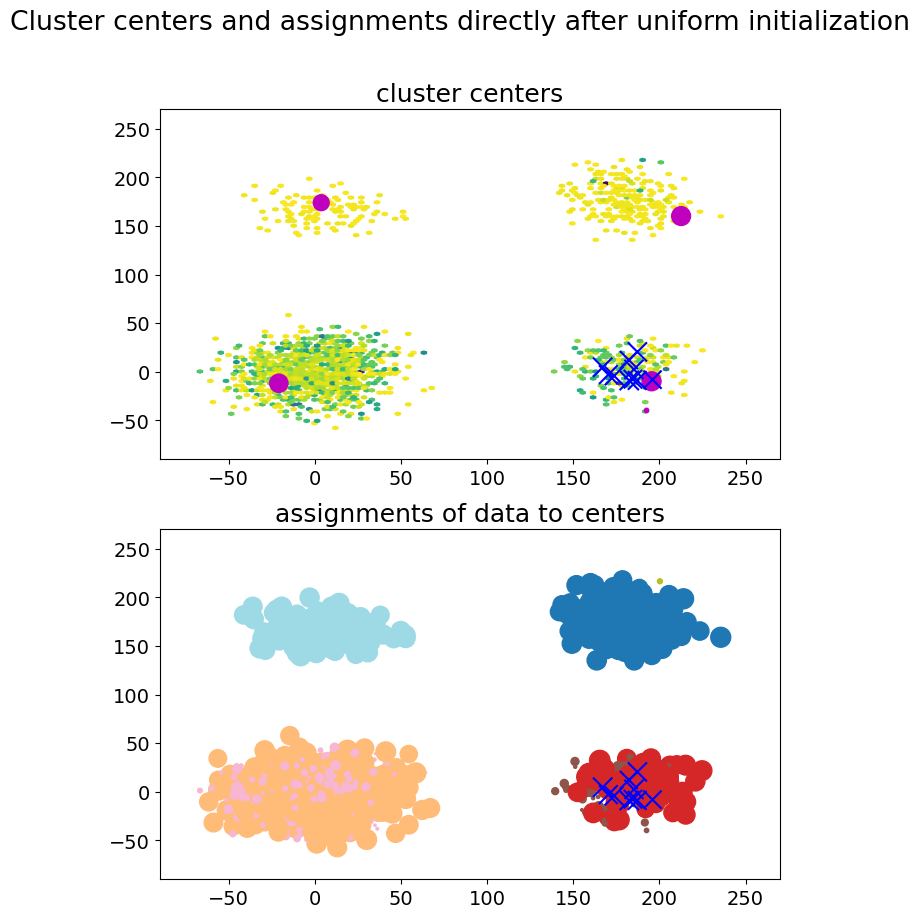

In [12]:
# Plotting the results
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))
f.suptitle('Cluster centers and assignments directly after uniform initialization')

# Adjust display range
x_min, x_max = -90, 270
y_min, y_max = -90, 270

# First plot: hexbin and cluster centers
ax1.hexbin(*(omegas.T), bins='log', label='GAFF1')
ax1.scatter(*(clustering.cluster_centers.T), marker='o', c='m', label='Clustering Center')
ax1.scatter(*(nmr_omegas.T), marker = 'x', c='b', label='NMR Structure')
ax1.axis('on')
ax1.set_xlim(x_min, x_max)  # Set x-axis range
ax1.set_ylim(y_min, y_max)  # Set y-axis range
ax1.set_title('cluster centers')

# Second plot: scatter plot of assignments
ax2.scatter(*(omegas.T), c=assignments, cmap='tab20',label='GAFF1')
ax2.scatter(*(nmr_omegas.T), marker = 'x', c='b',label='NMR Structure')
ax2.axis('on')
ax2.set_xlim(x_min, x_max)  # Set x-axis range
ax2.set_ylim(y_min, y_max)  # Set y-axis range
ax2.set_title('assignments of data to centers')

# Setting the legend
ax1.legend(loc='upper right', bbox_to_anchor=(1.5, 1.0), facecolor='white', edgecolor='k')
ax2.legend(loc='upper right', bbox_to_anchor=(1.5, 1.0), facecolor='white', edgecolor='k')


# Adjust spacing between subplots
#plt.subplots_adjust(wspace=0.5)  # Increase the horizontal space between subplots

# Adjust layout
plt.tight_layout()


# Show the plots
plt.show()

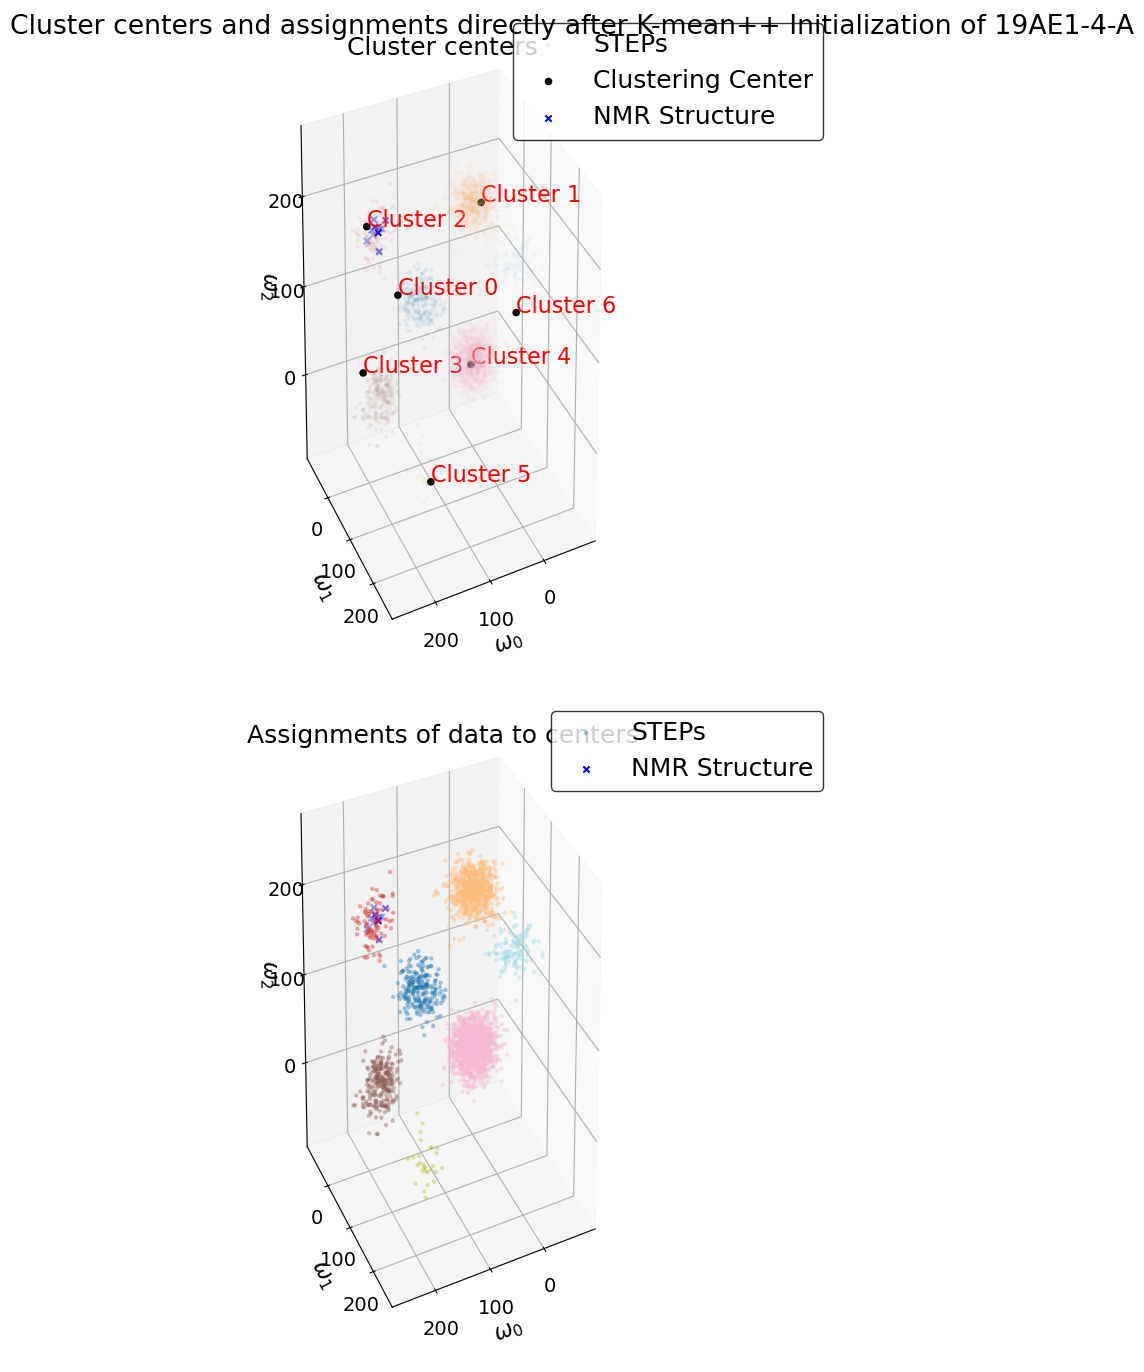

In [13]:
fig = plt.figure(figsize=(7, 14))

# Set the display range
x_min, x_max = -90, 270
y_min, y_max = -90, 270
z_min, z_max = -90, 270

# Viewing angles
elevation = 25  # Example elevation angle
azimuth = 65    # Example azimuthal angle

# Create a 3D subplot for cluster centers
ax1 = fig.add_subplot(211, projection='3d')
ax1.set_title('Cluster centers')
ax1.scatter(omegas[:, 0], omegas[:, 1], omegas[:, 2], c=assignments[:], marker='.', alpha=0.05,cmap='tab20',label='STEPs')
ax1.scatter(clustering.cluster_centers[:, 0], clustering.cluster_centers[:, 1], clustering.cluster_centers[:, 2], c='k', marker='o', alpha=1, label='Clustering Center')
ax1.scatter(*(nmr_omegas.T), marker = 'x', c='b', label='NMR Structure')
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min, y_max)
ax1.set_zlim(z_min, z_max)
ax1.view_init(elev=elevation, azim=azimuth)  # Set the viewing angle

# Label each cluster center
for i, (x, y, z) in enumerate(clustering.cluster_centers):
    ax1.text(x, y, z, f'Cluster {i}', color='red')

# Create a 3D subplot for assignments
ax2 = fig.add_subplot(212, projection='3d')
ax2.set_title('Assignments of data to centers')
ax2.scatter(omegas[:, 0], omegas[:, 1], omegas[:, 2], c=assignments[:], marker='.', alpha=0.3 , cmap='tab20', label='STEPs')
ax2.scatter(*(nmr_omegas.T), marker = 'x', c='b', label='NMR Structure')
ax2.set_xlim(x_min, x_max)
ax2.set_ylim(y_min, y_max)
ax2.set_zlim(z_min, z_max)
ax2.view_init(elev=elevation, azim=azimuth)  # Set the viewing angle

# Setting the legend
ax1.legend(loc='upper right', bbox_to_anchor=(1.5, 1.0), facecolor='white', edgecolor='k')
ax2.legend(loc='upper right', bbox_to_anchor=(1.5, 1.0), facecolor='white', edgecolor='k')

# Adding axis labels
ax1.set_xlabel(r'$\omega_0$')
ax1.set_ylabel(r'$\omega_1$')
ax1.set_zlabel(r'$\omega_2$')

ax2.set_xlabel(r'$\omega_0$')
ax2.set_ylabel(r'$\omega_1$')
ax2.set_zlabel(r'$\omega_2$')

# Adjust spacing between subplots
#plt.subplots_adjust(hspace=0.5)  # Increase the horizontal space between subplots

# Adjust layout
plt.tight_layout()

fig.suptitle('Cluster centers and assignments directly after K-mean++ Initialization of 19AE1-4-A')
fig.savefig('omega_data/cluster_centers_and_assignments.png',transparent=True, dpi=600, bbox_inches='tight')
plt.show()

### Sampling from Clusters

In [44]:
# Define the directory path
directory = "sampling/"

# Check if the directory exists
if os.path.exists(directory):
    # Remove all contents of the directory
    shutil.rmtree(directory)
    # Recreate the empty directory
    os.makedirs(directory)
    print(f"All contents in '{directory}' have been cleared.")
else:
    # Create the directory if it does not exist
    os.makedirs(directory)
    print(f"Directory '{directory}' did not exist, so it has been created.")

Directory 'sampling/' did not exist, so it has been created.


In [47]:
import numpy as np
import mdtraj as md

# Create Cluster Dictionary
cluster = {assignment: [] for assignment in np.unique(assignments)}
print(cluster)

# Store the frame index in each cluster
for index, assignment in enumerate(assignments):
    cluster[assignment].append(index)

print(type(cluster))

# Create Frame Dictionary
frames = {assignment: [] for assignment in np.unique(assignments)}

# Randomly sample 50 frames from each cluster
for i in range(8):
    if len(cluster[i]) > 0:
        indices = np.random.choice(cluster[i], size=100, replace=False)
        frames[i] = indices.tolist()

HREX_list = ['../HREX_1/', '../HREX_2/', '../HREX_3/', '../HREX_4/']
trajs = []
for HREX in HREX_list:    
    # Load trajectory
    xtcfile = f"{HREX}state_0/HREMD.part0001.xtc"
    grofile = f"{HREX}state_0/HREMD_peptoid_only.part0001.gro"
    traj = md.load(xtcfile, top=grofile)
    trajs.append(traj)

# Concatenate trajectories
concatenated_trajs = md.join(trajs)

# Save sampled frames to new xtc files
for cluster in frames:
    sampling = concatenated_trajs[frames[cluster]]    
    sampling.save_xtc(f"sampling/sample_state_0_cluster{cluster}.xtc")
    sampling.save_pdb(f"sampling/sample_state_0_cluster{cluster}.pdb")


{0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: []}
<class 'dict'>


In [52]:
!gmx grompp -f fake.mdp -c ../HREX_1/single_peptoid.gro -p ../HREX_1/single_peptoid.top -o fake.tpr -maxwarn 1


                      :-) GROMACS - gmx grompp, 2020.5 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:
     

In [53]:
%%bash

# copy a fake.tpr from other directory 
cp fake.tpr sampling/
cp ../HREX_1/single_peptoid.gro sampling/

cd 'sampling'

for cluster in {0..7}
do
    # Run the gmx trjconv command with the current cluster number and provide the necessary input
    echo "0" | gmx trjconv -f "sample_state_0_cluster${cluster}.xtc" -s "fake.tpr" -pbc whole -o "sample_state_0_cluster${cluster}_whole.xtc"
done

# Remove GROMACS backup files
rm \#*

cd ..

# Print the current working directory
pwd


                     :-) GROMACS - gmx trjconv, 2020.5 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:
     

Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'
Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'


                     :-) GROMACS - gmx trjconv, 2020.5 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:
     

Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'
Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'
Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'
Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'
Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'


                     :-) GROMACS - gmx trjconv, 2020.5 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:
     

Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for output
Selected 0: 'System'
/Users/starwingchen/Voelz_Lab/git/peptoid_ESM/HREX/analysis


In [55]:
# Save the whole xtc back into pdb using MDtraj

for cluster in range(8):
    xtcfile = f"sampling/sample_state_0_cluster{cluster}_whole.xtc"
    grofile = 'sampling/single_peptoid.gro'
    traj = md.load(xtcfile, top=grofile)
    
    output_pdbfile = f"sampling/sample_state_0_cluster{cluster}_whole.pdb"
    
    traj.save_pdb(output_pdbfile)